In [1]:
#%% Modules

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import torch as tc

from bptt.models import Model
import model_anafunctions as func
from tqdm import tqdm

from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

c:\Users\cestarellas\anaconda3\envs\PLAna\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#%% FUNCTIONS

def Avg_W_simulations(t_prev,t_post,xneu,Data_X,Data_Y,flag_state):
    # Function to simulate data from an average of W parameters across trials

    # Get parameters from the model
    _, W1t, W2t, _, _, Ct = m.get_latent_parameters()
    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)
    C = Ct.detach().numpy()

    # Computing W matrices for test trials
    W2_avg = tc.zeros((W2.shape[0],W2.shape[1]))
    W1_avg = tc.zeros((W1.shape[0],W1.shape[1]))
    W2_avg[:,:] = tc.from_numpy(W2[:,:,t_prev:t_post].mean(2)).float()
    W1_avg[:,:] = tc.from_numpy(W1[:,:,t_prev:t_post].mean(2)).float()

    W2_gen = [W2_avg for i in range(10)]
    W1_gen = [W1_avg for i in range(10)]

    #Generate Latent states
    ModelAvg = []
    #Generate Latent states
    data_X = tc.from_numpy(Data_X[t_prev][-2:-1,:]).float()
    ik=0
    for i in range(t_prev,t_post):
        input_trial=tc.from_numpy(Data_Y[i]).float()
        length_sim = input_trial.shape[0] 
        X, _ = m.generate_test_trajectory(data_X,W2_gen[ik],W1_gen[ik],input_trial,length_sim,i)
        ik+=1
        data_X = X[-2:-1,:]
        ModelAvg.append(X)
    Model_Average,_=func.concatenate_list(ModelAvg,0)

    Neuron_Average,_ = func.concatenate_list(Data_X[t_prev:t_post],0)

    # Reward and No Reward Trials
    Ext_input_average,_ = func.concatenate_list(Data_Y[t_prev:t_post],0)
    ini_trial = list(np.where(np.diff(Ext_input_average[:,0])==1.)[0]-49)
    end_trial = [ini_trial[i] for i in range(1,len(ini_trial))]+[Ext_input_average.shape[0]]

    Model_TAvg = [Model_Average[ini_trial[i]:end_trial[i],xneu] for i in range(len(ini_trial))]
    Neuron_TAvg = [Neuron_Average[ini_trial[i]:end_trial[i],xneu] for i in range(len(ini_trial))]
    Input_TAvg = [Ext_input_average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]

    if flag_state==1:
        state = 4.0
        pos_ext_input=1
    else:
        state = 1.0
        pos_ext_input=2

    len_trials = np.min([i.shape[0] for i in Model_TAvg])
    RewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)>0]
    NoRewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)==0]

    M_Reward = np.zeros((len(RewardT),len_trials))
    N_Reward = np.zeros((len(RewardT),len_trials))

    for i,k in enumerate(RewardT):
        M_Reward[i,:]=Model_TAvg[k][:len_trials].reshape(1,-1)
        N_Reward[i,:]=Neuron_TAvg[k][:len_trials].reshape(1,-1)

    M_NOReward = np.zeros((len(NoRewardT),len_trials))
    N_NOReward = np.zeros((len(NoRewardT),len_trials))

    for i,k in enumerate(NoRewardT):
        M_NOReward[i,:]=Model_TAvg[k][:len_trials].reshape(1,-1)
        N_NOReward[i,:]=Neuron_TAvg[k][:len_trials].reshape(1,-1)

    return M_Reward,N_Reward,M_NOReward,N_NOReward

def Avg_W_sessions(t_prev,t_post,Data_X,Data_Y,flag_state,m):
    # Function to simulate data from an average of W parameters across trials

    # Get parameters from the model
    _, W1t, W2t, _, _, Ct = m.get_latent_parameters()
    # Transform tensor to numpy format
    W2 = W2t.detach().numpy().transpose(1,2,0)
    W1 = W1t.detach().numpy().transpose(1,2,0)
    C = Ct.detach().numpy()

    # Computing W matrices for test trials
    W2_avg = tc.zeros((W2.shape[0],W2.shape[1]))
    W1_avg = tc.zeros((W1.shape[0],W1.shape[1]))
    W2_avg[:,:] = tc.from_numpy(W2[:,:,t_prev:t_post].mean(2)).float()
    W1_avg[:,:] = tc.from_numpy(W1[:,:,t_prev:t_post].mean(2)).float()

    W2_gen = [W2_avg for i in range(10)]
    W1_gen = [W1_avg for i in range(10)]

    #Generate Latent states
    ModelAvg = []
    #Generate Latent states
    data_X = tc.from_numpy(Data_X[t_prev][-2:-1,:]).float()
    ik=0
    for i in range(t_prev,t_post):
        input_trial=tc.from_numpy(Data_Y[i]).float()
        length_sim = input_trial.shape[0] 
        X, _ = m.generate_test_trajectory(data_X,W2_gen[ik],W1_gen[ik],input_trial,length_sim,i)
        ik+=1
        data_X = X[-2:-1,:]
        ModelAvg.append(X)
    Model_Average,_=func.concatenate_list(ModelAvg,0)

    Neuron_Average,_ = func.concatenate_list(Data_X[t_prev:t_post],0)

    # Reward and No Reward Trials
    Ext_input_average,_ = func.concatenate_list(Data_Y[t_prev:t_post],0)
    ini_trial = list(np.where(np.diff(Ext_input_average[:,0])==1.)[0]-49)
    end_trial = [ini_trial[i] for i in range(1,len(ini_trial))]+[Ext_input_average.shape[0]]

    Model_TAvg = [Model_Average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]
    Neuron_TAvg = [Neuron_Average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]
    Input_TAvg = [Ext_input_average[ini_trial[i]:end_trial[i],:] for i in range(len(ini_trial))]

    if flag_state==1:
        state = 4.0
        pos_ext_input=1
    else:
        state = 1.0
        pos_ext_input=2

    len_trials = np.min([i.shape[0] for i in Model_TAvg])
    RewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)>0]
    NoRewardT = [i for i in range(len(ini_trial)) if np.sum(Input_TAvg[i][:,pos_ext_input]==state)==0]

    M_Reward_N = []
    N_Reward_N = []
    for ineu in range(Model_TAvg[0].shape[1]):
        M_Reward = np.zeros((len(RewardT),len_trials))
        N_Reward = np.zeros((len(RewardT),len_trials))
        for i,k in enumerate(RewardT):
            M_Reward[i,:]=Model_TAvg[k][:len_trials,ineu].reshape(1,-1)
            N_Reward[i,:]=Neuron_TAvg[k][:len_trials,ineu].reshape(1,-1)
        M_Reward_N.append(M_Reward)
        N_Reward_N.append(N_Reward)
        
    M_NOReward_N = []
    N_NOReward_N = []
    for ineu in range(Model_TAvg[0].shape[1]):
        M_NOReward = np.zeros((len(NoRewardT),len_trials))
        N_NOReward = np.zeros((len(NoRewardT),len_trials))
        for i,k in enumerate(NoRewardT):
            M_NOReward[i,:]=Model_TAvg[k][:len_trials,ineu].reshape(1,-1)
            N_NOReward[i,:]=Neuron_TAvg[k][:len_trials,ineu].reshape(1,-1)
        M_NOReward_N.append(M_NOReward)
        N_NOReward_N.append(N_NOReward)
        
    # Reward Real
    reward_real = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(N_Reward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(N_Reward_N[ineu].mean(0),N_Reward_N[ineu][i,:])[0,1])
        reward_real.append(np.array(corr_list).mean())
    
    # Reward Generated
    reward_generated = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(M_Reward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(M_Reward_N[ineu].mean(0),N_Reward_N[ineu][i,:])[0,1])
        reward_generated.append(np.array(corr_list).mean())
    
    # NO Reward Real
    noreward_real = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(N_NOReward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(N_NOReward_N[ineu].mean(0),N_NOReward_N[ineu][i,:])[0,1])
        noreward_real.append(np.array(corr_list).mean())
    
    # NO Reward Generated
    noreward_generated = []
    for ineu in range(Model_TAvg[0].shape[1]):
        corr_list=[]
        for i in range(M_NOReward_N[ineu].shape[0]):
            corr_list.append(np.corrcoef(M_NOReward_N[ineu].mean(0),N_NOReward_N[ineu][i,:])[0,1])
        noreward_generated.append(np.array(corr_list).mean())
    
    return reward_real,reward_generated,noreward_real,noreward_generated


def Hyper_mod(mpath,data_path):
    file=open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),'rb')
    hyper=pickle.load(file)
    file.close()
    hyper['data_path']=os.path.join(data_path,'Training_data.npy').replace('\\','/')
    hyper['inputs_path']=os.path.join(data_path,'Training_inputs.npy').replace('\\','/')
    full_name = open(os.path.join(mpath,'hypers.pkl').replace("\\","/"),"wb")                      # Name for training data
    pickle.dump(hyper,full_name)            # Save train data
    #close save instance 
    full_name.close()

In [3]:
#%% Load Data and Behaviour
################################ Directories and files to modify ################################ 
# Select Path for multi-unit data
data_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets\\' 
#data_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/neuralactivity/OFC/CE17/L6/Test0/datasets/' 
# Select Path for Models (Folder containing the specific models to test)
model_path = 'D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\results'
#model_path = 'D:/_work_cestarellas/Analysis/PLRNN/noautoencoder/results/Tuning_OFC_CE17_221008'

# Loading models and simulations
model_name = 'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400\\001'
#'DataTrainingH768_lm1_1e-05_lm2_128_lm3_00_seql_400/001'
#model_name = 'CE1701_HU_256_l1_0.001_l2_08_l3_00_SL_400_encdim_65/001'
#Behaviour path
behaviour_path='D:/_work_cestarellas/Analysis/PLRNN/Session_Selected/OFC/CE17_L6'

## Loading recorded neuronal activity (pre-processesed)
mpath=os.path.join(model_path,model_name).replace('\\','/')

train_n,train_i = func.load_data(data_path,'Training')
test_n,test_i = func.load_data(data_path,'Test')
NeuronPattern={"Training_Neuron":train_n,"Training_Input":train_i,
               "Testing_Neuron":test_n,"Testing_Input":test_i}
Hyper_mod(mpath,data_path)
# Loading Model
num_epochs = 150000
m = Model()
m.init_from_model_path(mpath, epoch=num_epochs)
m.eval()

#meta information
Meta_file_path = "D:\\_work_cestarellas\\Analysis\\Pack_Daniel_project\\Preprocess_model\\bptt_CE17\\neuralactivity\\datasets\\Metadata.pkl"
# Open the file in binary mode
with open(Meta_file_path, "rb") as f:
    # Load the pickled data
    Meta_info = pickle.load(f)

Test_trials = Meta_info["TestTrials"]; Training_trials = Meta_info["TrainingTrials"]    
    
itrain = 0
itest = 0
Trials_inmodel = []
for i in range(len(Meta_info["TestTrials"])+len(Meta_info["TrainingTrials"])):
    if i in Meta_info["TrainingTrials"]:
        Trials_inmodel.append(np.sum(np.diff(train_i[itrain][:,0])==1))
        itrain += 1
    elif i in Meta_info["TestTrials"]:
        Trials_inmodel.append(np.sum(np.diff(test_i[itest][:,0])==1))
        itest +=1
        
# Cumulative sum of the behavioural trials in concatenated trials        
CUM_trials = [np.sum(Trials_inmodel[:i]) for i in range(len(Trials_inmodel)+1)]

Ini_beh = [0]+[CUM_trials[i+1] for i in Test_trials]
End_beh = [CUM_trials[i] for i in Test_trials]+[CUM_trials[-1]]

Tr_behaviour = []
for k in range(len(Ini_beh)):
    Tr_behaviour= Tr_behaviour+[i for i in range(Ini_beh[k],End_beh[k])]


Chosen model is clipped shPLRNN, the bases Parameter has no effect here!


In [4]:
#%% Behaviour.
# Info Columns BehData:
# 0- Trial Start
# 1- Trial End
# 2- Duration (Seconds)
# 3- Block
# 4- Gamble Arm (Right = 1, Left = 0)
# 5- Probability big Reward
# 6- Probability Small Reward
# 7- Ammount Big Reward
# 8- Ammount Small Reward
# 9- Number of previously wheel not stopping
# 10- Not responding Trial
# 11- Chosen Side (Right = 1, Left = 0)
# 12- Chosen Arm (Gamble = 1, Safe = 0)
# 13- Reward Given
# 14- Start of the trial (Sampling points)
# 15- Cue Presentation (Sampling Points)
# 16- Start of the response window (Sampling Points)
# 17- Reward Period (Sampling Points)
# 18- End of the trial

   # Pathway of the data (behaviour & Spike activity)

# Selection of the file
os.chdir(behaviour_path)
list_files = os.listdir(behaviour_path)
for i in list_files:
    if i.find('Behaviour')>0:
        Behaviour_name = i

# Load data
# Open the Behaviour file
Bdata = scipy.io.loadmat(Behaviour_name)
BehData = Bdata[list(Bdata.keys())[-1]]

# Classification of trials following the behabiour
GambleRewardTrials = np.where((BehData[:,12]==1) & (BehData[:,13]==1))[0]
GambleNoRewardTrials =  np.where((BehData[:,12]==1) & (BehData[:,13]==0))[0]
SafeRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==1))[0]
SafeNoRewardTrials = np.where((BehData[:,12]==0) & (BehData[:,13]==0))[0]
NoRespondingTrials = np.where(BehData[:,10]==1)[0]



In [5]:
# Creation of Virtual trials

# Behaviour Parameters

cue_0 = []
cue_s1 = []
Dec_prob = []
iti_l = []

for i in range(len(train_i)):
    id_trial = Training_trials[i]
    ini_c = np.where(np.diff(train_i[i][:,0])==1)[0]                                            # Cursor appearenced
    end_c = np.where(np.diff(train_i[i][:,0])==-1)[0]                                           # Cursor removed
    iti = np.diff(ini_c)-50.0                                                                   # Inter-trial duration
    dec_ratio =  np.mean(BehData[int(CUM_trials[id_trial]):int(CUM_trials[id_trial+1]),12])               # Probability of gamble choice

    cue_0.append(ini_c)
    cue_s1.append(end_c)
    iti_l.append(iti)
    Dec_prob.append(dec_ratio)

cue_0_array = np.concatenate(cue_0)
cue_s1_array = np.concatenate(cue_s1)
cue_dist=cue_s1_array-cue_0_array
iti_dist=np.concatenate(iti_l)

# Gamble Probability Reward
block_change = [22,45]
gamb_prob = []
for i in range(len(train_i)):
    if i<=block_change[0]:
        gamb_prob.append(0.75)
    elif i>block_change[0] & i<=block_change[1]:
        gamb_prob.append(0.12)
    else:
        gamb_prob.append(0.25)

# Safe Probability Reward
safe_prob=0.90


def virtual_trials(T_id, cue_dist, Dec_prob, gamb_prob, safe_prob, iti_dist):
    # Creation of virtual trials
    num_virtual_trial = 100
    virt_trial = np.zeros((1, 3))
    virt_dec = np.zeros(num_virtual_trial)
    virt_rew = np.zeros(num_virtual_trial)
    
    for vt in range(num_virtual_trial):
        wheel = np.zeros((50, 3))  # wheel stop 1s
        lcue = np.random.choice(cue_dist)
        cue = np.zeros((lcue, 3))
        cue[:, 0] = 1
        
        # Gamble choice
        if np.random.rand() <= Dec_prob[T_id]:
            virt_dec[vt] = 1
            # Probability of gamble reward
            if np.random.rand() < gamb_prob[T_id]:
                # Yes Reward
                virt_rew[vt] = 1
                reward = np.zeros((25, 3))
                reward[:, 1] = 4
            else:
                # No Reward
                reward = np.zeros((25, 3))
        # Safe choice
        else:
            if np.random.rand() < safe_prob:
                # Yes Reward
                virt_rew[vt] = 1
                reward = np.zeros((25, 3))
                reward[:, 2] = 1
            else:
                # No Reward
                reward = np.zeros((25, 3))
        
        iti_time = np.zeros((int(np.random.choice(iti_dist)), 3))
        ind_trial = np.vstack((wheel, cue, reward, iti_time))
        virt_trial = np.vstack((virt_trial, ind_trial))
    
    return virt_trial, virt_dec, virt_rew

# Example usage
T_id = 0
virt_trial, virt_dec, virt_rew = virtual_trials(T_id, cue_dist, Dec_prob, gamb_prob, safe_prob, iti_dist)


In [6]:
# Simulating Training Data
ModelS=[]
for w_index in tqdm(range(len(NeuronPattern["Training_Neuron"]))):
    data_trial=tc.from_numpy(NeuronPattern["Training_Neuron"][w_index]).float()          # tensor of neuronal data for initial trial data
    # Example usage
    T_id = 0
    virt_trial,_,_ = virtual_trials(T_id, cue_dist, Dec_prob, gamb_prob, safe_prob, iti_dist)
    input_trial = tc.from_numpy(virt_trial).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelS.append(X[:,:])


100%|██████████| 55/55 [03:31<00:00,  3.85s/it]


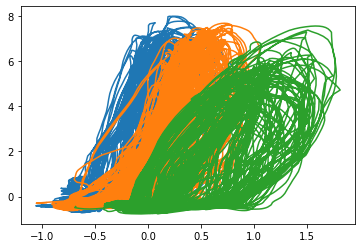

In [15]:
# Full simulation of the session. Following behavioural distributions
plt.figure()
plt.plot(ModelS[8][:,5],ModelS[8][:,8])
plt.plot(ModelS[15][:,5],ModelS[15][:,8])
plt.plot(ModelS[20][:,5],ModelS[20][:,8])

In [8]:
## Main goal: Comparing Gamble and Safe reward activity

# Gamble reward: Forcing the system the gamble choice and obtaining reward
gamb_choice = [1.0]*len(gamb_prob)
rew_prob = [1.0]*len(gamb_prob)
# Simulating Training Data
ModelGR=[]
ModelSR=[]
for w_index in tqdm(range(len(NeuronPattern["Training_Neuron"]))):
    data_trial=tc.from_numpy(NeuronPattern["Training_Neuron"][w_index]).float()          # tensor of neuronal data for initial trial data
    # Example usage
    T_id = 0
    virt_trial,_,_ = virtual_trials(T_id, cue_dist, gamb_choice, rew_prob, safe_prob, iti_dist)
    input_trial = tc.from_numpy(virt_trial).float()
    length_sim = input_trial.shape[0]
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelGR.append(X[:,:])
    reverse_reward=np.where(virt_trial[:,1]==4)
    virt_trial[reverse_reward,1] = 0
    virt_trial[reverse_reward,2] = 0
    input_trial = tc.from_numpy(virt_trial).float()
    X, _ = m.generate_free_trajectory(data_trial,input_trial,length_sim,w_index)
    ModelSR.append(X[:,:])


100%|██████████| 55/55 [06:57<00:00,  7.60s/it]


In [9]:
np.where(virt_trial[:,2]==1.0)

(array([], dtype=int64),)

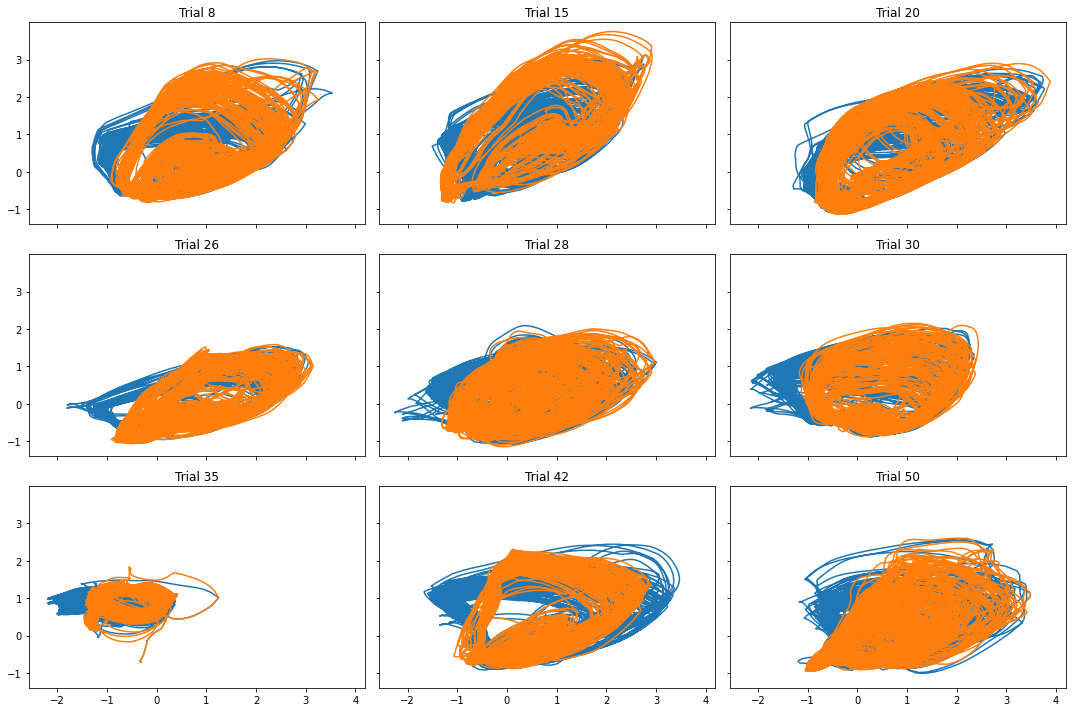

In [19]:
Trial_selection = [8,15,20,26,28,30,35,42,50]
ineu1 =25
ineu2 =56
# Create a figure and a 3x2 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 10),sharex=True,sharey = True)
# Example of plotting in each subplot
index = -1
for i in range(3):
    for j in range(3):
        index +=1
        axs[i, j].plot(ModelGR[Trial_selection[index]][:,ineu1],ModelGR[Trial_selection[index]][:,ineu2]) 
        axs[i, j].plot(ModelSR[Trial_selection[index]][:,ineu1],ModelSR[Trial_selection[index]][:,ineu2]) 
        axs[i, j].set_title(f'Trial {Trial_selection[index]}')

# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()


In [20]:
dist = []
for i in range(len(ModelGR)):
    Diff_trajectories = tc.sqrt(tc.sum((ModelGR[i]-ModelSR[i])**2,1))
    dist.append(Diff_trajectories.mean())

In [21]:
Diff_trajectories.mean()

tensor(6.8139)

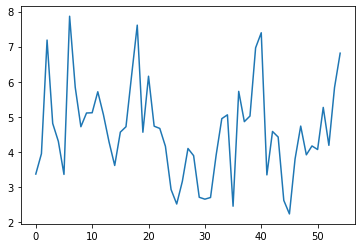

In [22]:
plt.figure()
plt.plot(dist)

In [23]:
## Main goal: Simulation of a specific scenario for all trials
ModelGR[0].shape
# specific sceneario: GR-GR-GR-GN

torch.Size([32192, 57])